In [1]:
import matplotlib

import matplotlib.pyplot as plt
import DMK_go_coude as Fns
import numpy as np
import os, readcol
import scipy.optimize as optim
import scipy.interpolate as interp
import pickle

from astropy.io import fits 
from mpfit import mpfit
from scipy import signal

In [2]:
dir = os.getenv("HOME") + '/Research/YMG/coude_data/20140321/'
rdir = dir + 'reduction/'
# codedir = os.getenv("HOME") + '/codes/coudereduction/'
codedir = os.getenv("HOME") + '/Research/Codes/coudereduction/'

In [3]:
os.chdir(dir)

In [4]:
DarkCurVal = 0.0

InfoFile = 'headstrip.csv'
FileInfo = readcol.readcol( InfoFile, fsep = ',', asRecArray = True )
DarkCube = FileInfo.ExpTime * DarkCurVal

BiasInds = np.where( FileInfo.Type == 'zero' )[0]
FlatInds = np.where( FileInfo.Type == 'flat' )[0]
ArcInds  = np.where( (FileInfo.Type == 'comp') & ( (FileInfo.Object == 'Thar') | (FileInfo.Object == 'THAR') | (FileInfo.Object == 'A') ) )[0]
ObjInds  = np.where( (FileInfo.Type == 'object') & (FileInfo.Object != 'SolPort') & (FileInfo.Object != 'solar port') & (FileInfo.Object != 'solar_ort') )[0]

CalsDone = True
SuperBias, FlatField = Fns.Basic_Cals( FileInfo.File[BiasInds], FileInfo.File[FlatInds], CalsDone, rdir, plots = False )

ShowBPM = False
BPM = Fns.Make_BPM( SuperBias, FlatField, 99.9, ShowBPM )

RdNoise  = FileInfo.rdn[ArcInds] / FileInfo.gain[ArcInds]
DarkCur  = DarkCube[ArcInds] / FileInfo.gain[ArcInds]
ArcCube, ArcSNR = Fns.Make_Cube( FileInfo.File[ArcInds], RdNoise, DarkCur, Bias = SuperBias )

RdNoise  = FileInfo.rdn[ObjInds] / FileInfo.gain[ObjInds]
DarkCur  = DarkCube[ObjInds] / FileInfo.gain[ObjInds]
ObjCube, ObjSNR = Fns.Make_Cube( FileInfo.File[ObjInds], RdNoise, DarkCur, Bias = SuperBias, Flat = FlatField, BPM = BPM )

OrderStart = -32
TraceDone = True
MedCut = 95.0
MedTrace, FitTrace = Fns.Get_Trace( FlatField, ObjCube, OrderStart, MedCut, rdir, TraceDone, plots = False )

spec       = pickle.load(open(rdir+'extracted_spec_oldway.pkl','rb'))
sig_spec   = pickle.load(open(rdir+'extracted_sigspec_oldway.pkl','rb'))
wspec      = pickle.load(open(rdir+'extracted_wspec_oldway.pkl','rb'))
sig_wspec  = pickle.load(open(rdir+'extracted_sigwspec_oldway.pkl','rb'))

wspec      = wspec[:,::-1,:]
sig_wspec  = sig_wspec[:,::-1,:]
spec       = spec[:,::-1,:]
sig_spec   = sig_spec[:,::-1,:]

Reading in premade Bias and Flat files


DMK_go_coude.py:131: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
DMK_go_coude.py:132: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
DMK_go_coude.py:132: RuntimeWarning: divide by zero encountered in divide
DMK_go_coude.py:132: RuntimeWarning: invalid value encountered in divide
/anaconda/lib/python2.7/site-packages/numpy/lib/function_base.py:3858: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


Reading in premade Trace and plotting on Flat:


In [5]:
#fullspec, fullsig_spec = Fns.extractor( ObjCube, ObjSNR, FitTrace, quick = False, nosub = False, arc = False )

In [6]:
def Gaussian( x, A, mean, sigma, const ):
    gauss = A * np.exp( - ( x - mean ) ** 2.0 / ( 2.0 * sigma ** 2 ) ) + const
    return gauss

In [11]:
# def Get_WavSol( Cube, RoughSol, snr, plots = True ):
    
#     fullwavsol = np.zeros( ( Cube.shape[0], Cube.shape[1], Cube.shape[2] ) )
#     fullparams = np.zeros( ( Cube.shape[0], Cube.shape[1], 5 ) )
    
#     for frame in range( Cube.shape[0] ):
#         for i in range( Cube.shape[1] ):
            
def Get_WavSol_Order( Cube, RoughSol, OrderToFit, snr, plots = True ):
    
    orderdif = Cube.shape[1] - RoughSol.shape[0]
    
    arcspec   = Cube[0, OrderToFit, :]
    startwsol = RoughSol[OrderToFit - orderdif]
    
#     arcspec = Cube[0,OrderToFit,:]
#     startwsol = RoughSol
    
    arcspec           = arcspec - np.min( arcspec )
    belowmed          = np.where( arcspec < np.median( arcspec ) )
    arcspec[belowmed] = np.median( arcspec )
    logarcspec        = np.log10( arcspec )
    logarcspec        = logarcspec - np.min( logarcspec )
        
    THAR        = fits.open( codedir + 'thar_photron.fits' )[0]
    THARhead    = THAR.header
    THARspec    = THAR.data
    THARwav     = np.arange( len( THARspec ) ) * THARhead['CDELT1'] + THARhead['CRVAL1']
    THARlines   = readcol.readcol( codedir + 'ThAr_list.txt', asRecArray = True )
    logTHARspec = np.log10(THARspec)

    wavsols, peakskeep, peaksrej, params = Fit_WavSol( startwsol, arcspec, THARlines.wav, snr, minsep = 1.5, plots = plots )

#     pickle.dump( peakskeep, open( rdir + 'peaks_keep_ord' + str(OrderToFit) + '.pkl', 'wb' ) )
#     pickle.dump( peaksrej, open( rdir + 'peaks_rej_ord' + str(OrderToFit) + '.pkl', 'wb' ) )
    
    if plots == True:
        plt.clf()
        plt.plot( wavsols[-1], logarcspec, 'k-' )
        plt.plot( THARwav, logTHARspec, 'r-' )
        plt.xlim( wavsols[-1,0], wavsols[-1,-1] )
        for peak in peakskeep['wav']:
            plt.axvline( x = peak, color = 'b', ls = ':' )
        plt.show()

        Plot_Wavsol_Windows( wavsols, peakskeep['wav'], logarcspec, THARwav, logTHARspec )
    
    return wavsols, params

def Plot_Wavsol_Windows( wavsols, wavkeep, spec, tharwav, tharspec ):
    
    plotwav  = wavsols[-1]
    startwav = np.min( plotwav )
    
    while startwav <= np.max( plotwav ):
        plt.clf()
        plt.plot( plotwav, spec, 'k-' )
        plt.plot( tharwav, tharspec, 'r-' )
        plt.xlim( startwav, startwav + 10 )
        for peak in wavkeep:
            plt.axvline( x = peak, color = 'b', ls = ':' )
        plt.show()
        
        startwav += 10
        
    return None

def Plot_WavSol_Resids( wavresids, velresids, wavabsdev, velabsdev, lines, tokeep = None, toreject = None ):
    
    plt.clf()
    fig, (wavax, velax) = plt.subplots( 2, 1, sharex = 'all' )
    wavax.axhline( y = 0.0, color = 'k', ls = ':' )
    velax.axhline( y = 0.0, color = 'k', ls = ':' )
    if toreject == None:
        wavax.plot( lines, wavresids, 'ko', mfc = 'none' )
        velax.plot( lines, velresids, 'ko', mfc = 'none' )
    else:
        wavax.plot( lines[tokeep], wavresids[tokeep], 'ko', mfc = 'none' )
        wavax.plot( lines[toreject], wavresids[toreject], 'kx' )
        velax.plot( lines[tokeep], velresids[tokeep], 'ko', mfc = 'none' )
        velax.plot( lines[toreject], velresids[toreject], 'kx' )
    for x in [ -3, 3 ]:
        wavax.axhline( y = x * np.median( wavabsdev ), color = 'r', ls = '--' )
        velax.axhline( y = x * np.median( velabsdev ), color = 'r', ls = '--' )
    wavax.set_ylabel( 'Resids ($\AA$)' )
    velax.set_ylabel( 'Resids (km/s)' )
    fig.subplots_adjust( hspace = 0 )
    plt.show()
    
    return None

In [8]:
def Find_Peaks( wav, spec, peaksnr = 5, pwidth = 10, minsep = 1 ):
    
    # Find peaks using the cwt routine from scipy.signal
    peaks = signal.find_peaks_cwt( spec, np.arange( 1, 2 ), min_snr = peaksnr, noise_perc = 20 )
    
    # Offset from start/end of spectrum by some number of pixels
    peaks = peaks[ (peaks > pwidth) & (peaks < len(spec) - pwidth) ]
    
    pixcent = np.array([])
    wavcent = np.array([])
        
    for peak in peaks:
        
        xi   = wav[peak - pwidth:peak + pwidth]
        yi   = spec[peak - pwidth:peak + pwidth]
        inds = np.arange( len(xi), dtype = float )
        
        pguess   = [ yi[9], np.median( inds ), 0.9, np.median( spec ) ]
        lowerbds = [ 0.1*pguess[0], pguess[1] - 2.0, 0.3, 0.0  ]
        upperbds = [ np.inf, pguess[1] + 2.0, 1.5, np.inf ]
        
        try:
            params, pcov = optim.curve_fit( Gaussian, inds, yi, p0 = pguess, bounds = (lowerbds,upperbds) )
            
            pixval  = peak - pwidth + params[1]
            pixcent = np.append( pixcent, pixval )
            
            ceiling = np.ceil( pixval ).astype(int)
            floor   = np.floor( pixval ).astype(int)
            slope   = ( wav[ceiling] - wav[floor] ) / ( ceiling - floor )
            wavval  = wav[floor] + slope * ( pixval - floor )
            wavcent = np.append( wavcent, wavval )
            
        except RuntimeError:
            pixval  = 'nan'
            
    vals = spec[pixcent.astype(int)]
    oks  = np.ones( len(pixcent), int )
    
    for i in range( len(wavcent) ):
        dist  = np.absolute( wavcent - wavcent[i] )
        close = np.where( dist <= minsep )[0]
        small = np.where( vals[close] < np.max( vals[close] ) )[0]
        if len(small) != 0: oks[close[small]] = -1
            
    keep    = np.where( oks == 1 )
    pixcent = pixcent[keep]
    wavcent = wavcent[keep]
            
    return pixcent, wavcent

def Fit_WavSol( wav, spec, linecatalog, snr = 50, pwidth = 10, minsep = 1, plots = True ):
    
    wavsols    = np.zeros( ( 2, len(spec) ) )
    wavsols[0] = wav
    
    pixcent, wavcent = Find_Peaks( wavsols[0], spec, peaksnr = snr, minsep = minsep )
    
    THARthisord = [ line for line in linecatalog if line > wavsols[0,0] and line < wavsols[0,-1] ]
    
    keeps = { 'pix': np.array([]), 'wav': np.array([]), 'line': np.array([]) }
    rejs  = { 'pix': np.array([]), 'wav': np.array([]), 'line': np.array([]) }
    
    for i in range( len(wavcent) ):
        dists    = np.absolute( THARthisord - wavcent[i] )
        mindist  = np.min( dists )
        mindisti = np.argmin( dists )
            
        if mindist <= 1.5:
            keeps['pix']  = np.append( keeps['pix'], pixcent[i] )
            keeps['wav']  = np.append( keeps['wav'], wavcent[i] )
            keeps['line'] = np.append( keeps['line'], THARthisord[mindisti] )
            
    dofit = True
    
    while dofit:
        wavparams  = np.polyfit( keeps['pix'], keeps['line'], 4 )
        ptsfromfit = np.polyval( wavparams, keeps['pix'] )
            
        wavresids  = ptsfromfit - keeps['line']
        wavabsdev  = np.absolute( wavresids )

        velresids  = wavresids / keeps['line'] * 3e5
        velabsdev  = np.absolute( velresids )
            
        abovekms   = len( np.where( velresids >= 1.0 )[0] )
            
        torej      = wavabsdev >= 3.0 * np.median( wavabsdev )
        tokeep     = np.logical_not( torej )
        numrej     = len( np.where( torej == True )[0] )
        
        if abovekms > 0:
            if numrej > 0:
                if plots:
                    Plot_WavSol_Resids( wavresids, velresids, wavabsdev, velabsdev, keeps['line'], tokeep = tokeep, toreject = torej )
                
                rejs['pix']  = keeps['pix'][torej]
                rejs['wav']  = keeps['wav'][torej]
                rejs['line'] = keeps['line'][torej]
                
                keeps['pix']  = keeps['pix'][tokeep]
                keeps['wav']  = keeps['wav'][tokeep]
                keeps['line'] = keeps['line'][tokeep]
                
            else:
                print 'There is something seriously wrong.\n'
                print 'There are points > 1 km/s, but none are found to be rejected. FIX'
                break

        else:
            if plots:
                Plot_WavSol_Resids( wavresids, velresids, wavabsdev, velabsdev, keeps['line'] )
                print 'No points are worse than 1 km/s, fit good.'
            dofit = False
            
    wavsols[1] = np.polyval( wavparams, np.arange( len(spec) ) )

    return wavsols, keeps, rejs, wavparams

In [9]:
#testord = wspec.shape[1] - 15 - 1
testord = 41
oldwsol = pickle.load( open( codedir + 'global_wsol_arizz.pkl', 'rb' ) )[0]
oldord  = testord - ( wspec.shape[1] - oldwsol.shape[0] )

print testord, oldord

41 30


Removing 1 rows that don't match most common length 2.                       
4168 rows read into array.


/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in log10
/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in log10
/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:74: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


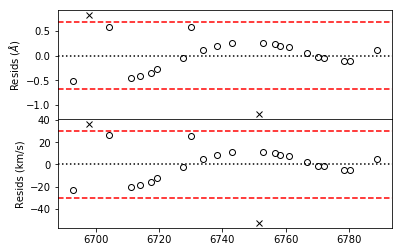

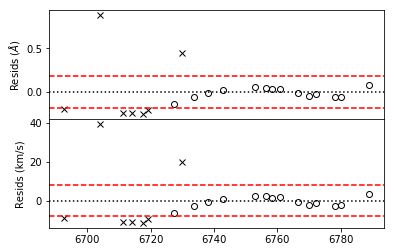

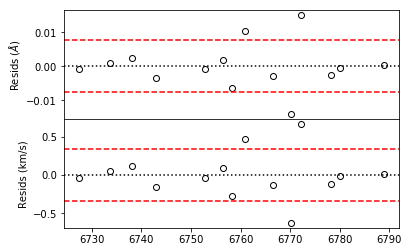

No points are worse than 1 km/s, fit good.


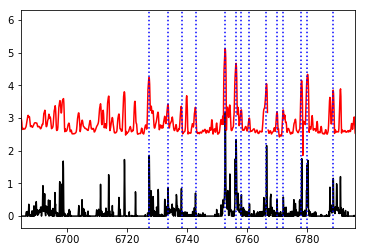

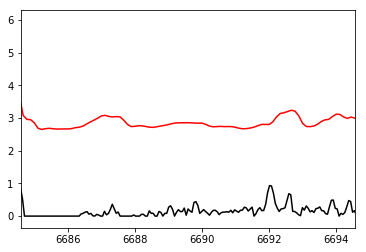

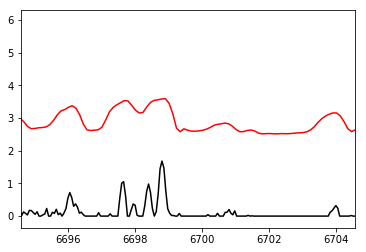

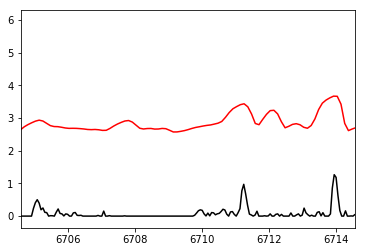

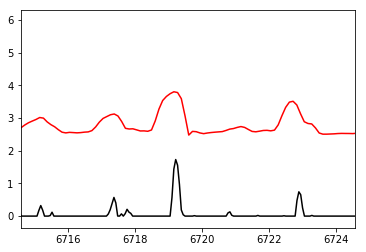

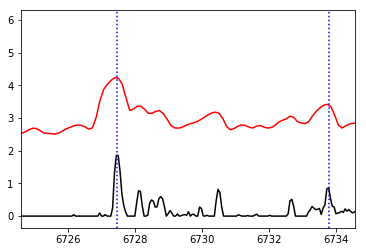

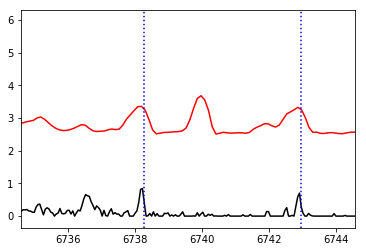

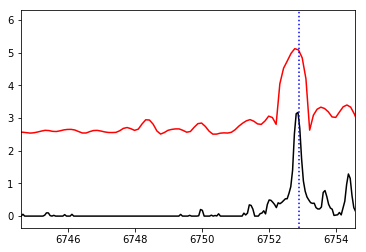

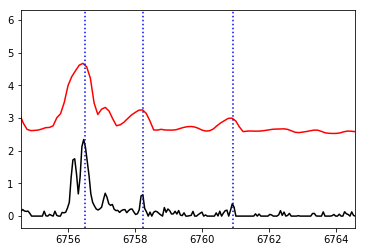

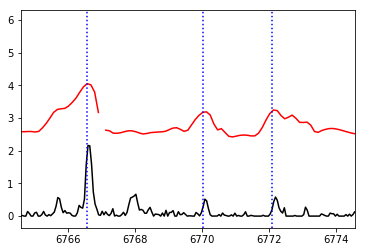

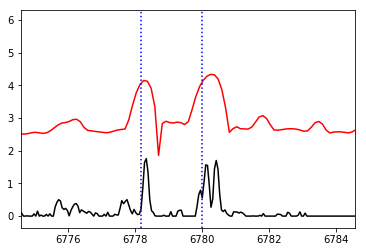

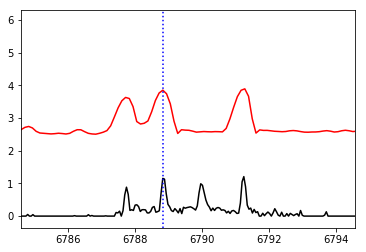

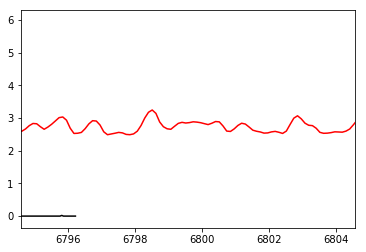

In [12]:
wavsols, params = Get_WavSol_Order( wspec, oldwsol, testord, 5 )

In [ ]:
print testord
print np.min( wavsols[-1] )
print np.max( wavsols[-1] )
print params

In [ ]:
obj = 43
plt.clf()
plt.plot( wavsols[-1], spec[obj,testord,:], 'k-' )
plt.xlim( 6700, 6720 )
plt.ylim( 13000, 15000 )
plt.show()

In [ ]:
class Click_WavSol():
    '''
    A class for handling listening for user clicks on matplotlib plots and passing the 
    coordinates for use in the wavelength calibration.
    '''
    def __init__(self, obswav, obsarc, calwav, calarc, extrax = None, extray = None):
        self.obswav = obswav
        self.obsarc = obsarc
        self.calwav = calwav
        self.calarc = calarc
        self.extrax = extrax
        self.extray = extray
        self.clicks = []
        
    def getcoord(self):
        
#         startwav = np.min( self.obswav ) - 5.0
        
#         while startwav < np.max( self.obswav ) + 5.0:
#             print startwav
#             plt.clf()
#             plt.plot( self.calwav, self.calarc, 'r-' )
#             plt.plot( self.obswav, self.obsarc, 'k-' )
#             plt.xlim( startwav, startwav + 10.0 )
            
#             fig = plt.gcf()
#             cid = fig.canvas.mpl_connect( 'button_press_event', self.__onclick__ )
#             plt.show()
            
#             raw_input( 'Continue?' )
            
#             startwav += 10.0
            
        plt.clf()
        plt.plot( self.calwav, self.calarc, 'r-' )
        plt.plot( self.obswav, self.obsarc, 'k-' )
        plt.xlim( np.min( self.obswav ) - 5.0, np.max( self.obswav ) + 5.0 )
        
        fig    = plt.gcf()
        cidobs = fig.canvas.mpl_connect( 'key_press_event', self.__obskey__ )
        plt.show()
        
        return self.clicks

    def __obskey__(self, click):
        point = [click.xdata, click.ydata]
        print click.key
        print click.xdata, click.ydata
        print click.x, click.y
        return self.clicks.append(point)

In [ ]:
order = 10

arcspec           = wspec[0, order, :]
arcspec           = arcspec - np.min( arcspec )
belowmed          = np.where( arcspec < np.median( arcspec ) )
arcspec[belowmed] = np.median( arcspec )
logarcspec        = np.log10( arcspec )
logarcspec        = logarcspec - np.min( logarcspec )

midwav   = 4192.0
disp     = midwav / 60000.0 / 2.0
roughwav = np.linspace( midwav - disp * 1024, midwav + disp * 1024, len(arcspec) )

THAR        = fits.open( codedir + 'thar_photron.fits' )[0]
THARhead    = THAR.header
THARspec    = THAR.data
THARwav     = np.arange( len( THARspec ) ) * THARhead['CDELT1'] + THARhead['CRVAL1']
THARlines   = readcol.readcol( codedir + 'ThAr_list.txt', asRecArray = True )
logTHARspec = np.log10(THARspec)

lpoint = Click_WavSol( roughwav, logarcspec, THARwav, logTHARspec )
lpoint.getcoord()

In [ ]:
wavsols, wavparams = Get_WavSol_Order( wspec, roughwav, order, 5 )

In [ ]:
order = 10   
    
arcspec   = wspec[0, order, :]
    
arcspec           = arcspec - np.min( arcspec )
belowmed          = np.where( arcspec < np.median( arcspec ) )
arcspec[belowmed] = np.median( arcspec )
logarcspec        = np.log10( arcspec )
logarcspec        = logarcspec - np.min( logarcspec )
        
maxwav   = 4226.6
minwav   = 4157.3
roughwav = np.linspace( minwav, maxwav, len(arcspec) )

THAR        = fits.open( codedir + 'thar_photron.fits' )[0]
THARhead    = THAR.header
THARspec    = THAR.data
THARwav     = np.arange( len( THARspec ) ) * THARhead['CDELT1'] + THARhead['CRVAL1']
THARlines   = readcol.readcol( codedir + 'ThAr_list.txt', asRecArray = True )
logTHARspec = np.log10(THARspec)

plt.clf()
plt.plot( roughwav, logarcspec, 'k-' )
plt.plot( THARwav, logTHARspec, 'r-' )
plt.xlim( minwav, maxwav )
plt.show()